# Homework: Irma Avdic



## Summary:


*   Batch size (64, 128, 320): the batch size primarily affected the smoothness of the loss per epoch function. When using a smaller batch size, the training and validation loss were both notably steeper than when a larger batch size was used.  

*   Learning rate (0.025, 0.075, 0.100): with increasing learning rate, the difference between the training and validation accuracy also increased. The validation accuracy grew with respect to the learning rate. The wall time was slightly higher for the lowest learning rate studied.

*   Activation functions (tanh, ELU, GELU): GELU resulted in the lowest accuracy among the three compared activation functions while ELU performed "the best" considering resulting accuracy and CPU and wall times. Only with tanh, the validation accuracy exceeded the training accuracy at certain epochs.


## Bonus:

A learning rate scheduler is a dynamic adaptation of the learning rate per epoch that may offer the most flexibility in tuning a model. Typically, the learning rate is being lowered as the epochs/iterations progress.





In [3]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy
import matplotlib.pyplot as plt
import time

In [4]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 14020285.06it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 427811.54it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 3901378.31it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 2990663.86it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [6]:
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        # First, we need to convert the input image to a vector by using
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()

        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)

    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)

        return x

In [7]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.05)

LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


In [8]:
batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [9]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

In [10]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size

    accuracy = 100*correct
    return accuracy, loss

## Batch Size Tuning

### Batch size = 128

In [19]:
#create dataloader for test data
# The dataloader makes our dataset iterable
batch_size_test = 128
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [20]:
acc_test, loss_test = evaluate(test_dataloader, linear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 2.3516, test accuracy: 6.47%


In [21]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])

    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


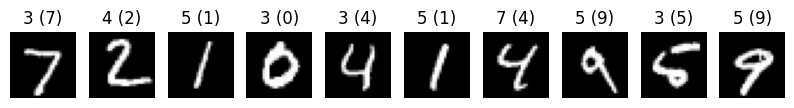

In [22]:
show_failures(linear_model, test_dataloader)

<!-- # Exercise:
- Try changing the loss function,
- Try changing the optimizer -->

In [23]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [24]:
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [25]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.7712074794769287, accuracy: 79.47291666666668
Epoch 0: val. loss: 0.7656994373240369, val. accuracy: 79.54166666666667
Epoch 1: training loss: 0.379974342862765, accuracy: 89.27916666666667
Epoch 1: val. loss: 0.3706103520507508, val. accuracy: 89.15833333333333
Epoch 2: training loss: 0.29993227251370747, accuracy: 91.32916666666667
Epoch 2: val. loss: 0.29355778814630307, val. accuracy: 91.10000000000001
Epoch 3: training loss: 0.25264196944236755, accuracy: 92.61041666666667
Epoch 3: val. loss: 0.24852294387652518, val. accuracy: 92.475
Epoch 4: training loss: 0.21360827392339707, accuracy: 93.74375
Epoch 4: val. loss: 0.21281522773998848, val. accuracy: 93.46666666666667
CPU times: user 1min 1s, sys: 144 ms, total: 1min 1s
Wall time: 1min 1s


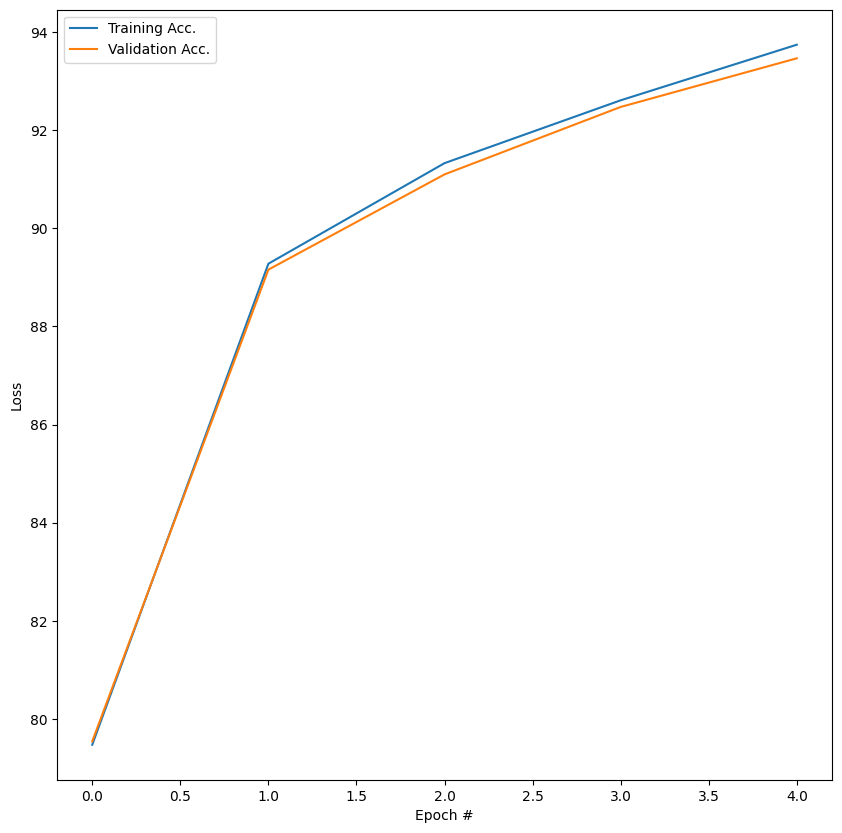

In [26]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


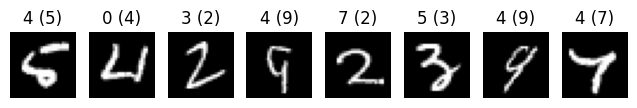

In [27]:
show_failures(nonlinear_model, test_dataloader)

### Batch size = 64

In [28]:
#create dataloader for test data
# The dataloader makes our dataset iterable
batch_size_test = 64
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [29]:
acc_test, loss_test = evaluate(test_dataloader, linear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 2.3520, test accuracy: 6.47%


Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


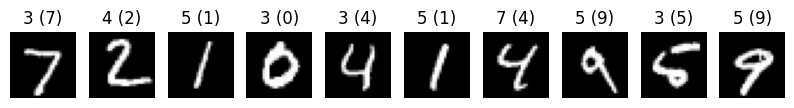

In [30]:
show_failures(linear_model, test_dataloader)

In [31]:
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [32]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.7269549773534139, accuracy: 78.27708333333334
Epoch 0: val. loss: 0.7151876066593413, val. accuracy: 77.925
Epoch 1: training loss: 0.41448646593093874, accuracy: 88.31875
Epoch 1: val. loss: 0.40424833113842823, val. accuracy: 88.44999999999999
Epoch 2: training loss: 0.30875520726044975, accuracy: 91.28958333333334
Epoch 2: val. loss: 0.3001754250615201, val. accuracy: 91.18333333333334
Epoch 3: training loss: 0.2533104243675868, accuracy: 92.71249999999999
Epoch 3: val. loss: 0.24663398969680705, val. accuracy: 92.56666666666666
Epoch 4: training loss: 0.21201351594924928, accuracy: 93.97083333333333
Epoch 4: val. loss: 0.20814699473533224, val. accuracy: 93.79166666666666
CPU times: user 59.4 s, sys: 109 ms, total: 59.5 s
Wall time: 1min


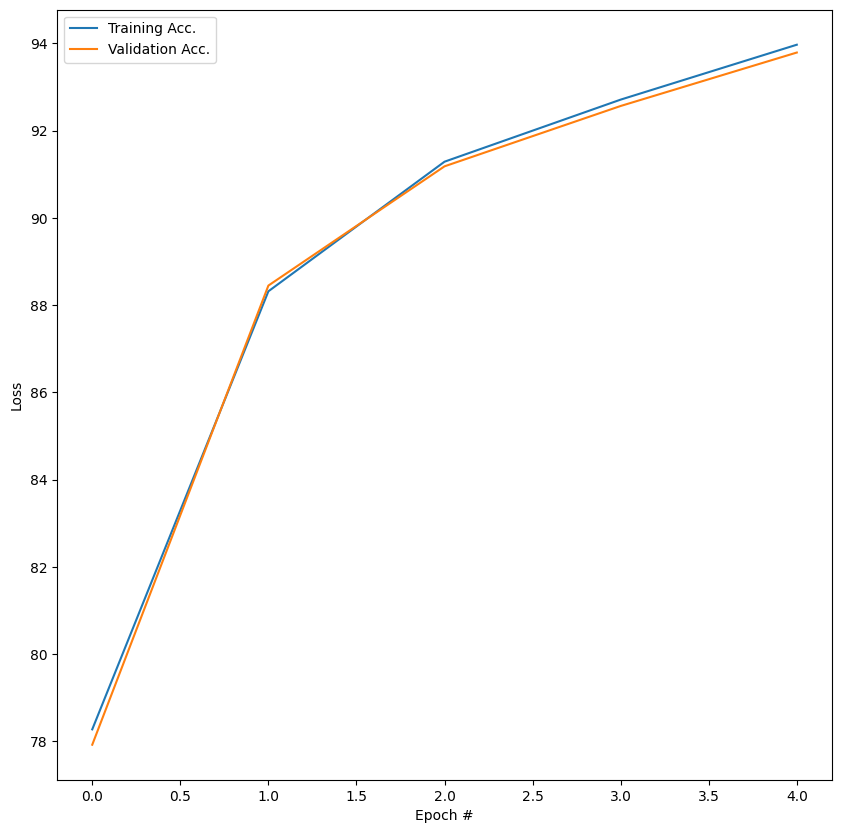

In [33]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

### Batch size = 320

In [34]:
batch_size_test = 320
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [35]:
acc_test, loss_test = evaluate(test_dataloader, linear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 2.3513, test accuracy: 6.47%


Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


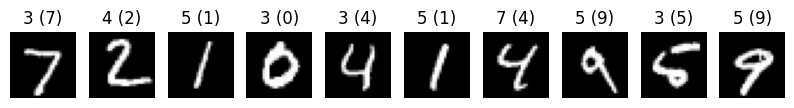

In [36]:
show_failures(linear_model, test_dataloader)

In [37]:
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [38]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.8614029583930969, accuracy: 75.27083333333333
Epoch 0: val. loss: 0.8592554590803512, val. accuracy: 74.26666666666667
Epoch 1: training loss: 0.3968787255684535, accuracy: 88.70208333333333
Epoch 1: val. loss: 0.3916331466208113, val. accuracy: 88.69166666666666
Epoch 2: training loss: 0.3068945775826772, accuracy: 91.06666666666666
Epoch 2: val. loss: 0.30123586477117337, val. accuracy: 91.06666666666666
Epoch 3: training loss: 0.2509053289095561, accuracy: 92.5625
Epoch 3: val. loss: 0.2479642113631076, val. accuracy: 92.4
Epoch 4: training loss: 0.2125920197168986, accuracy: 93.77499999999999
Epoch 4: val. loss: 0.2126580499746698, val. accuracy: 93.46666666666667
CPU times: user 1min, sys: 140 ms, total: 1min
Wall time: 1min


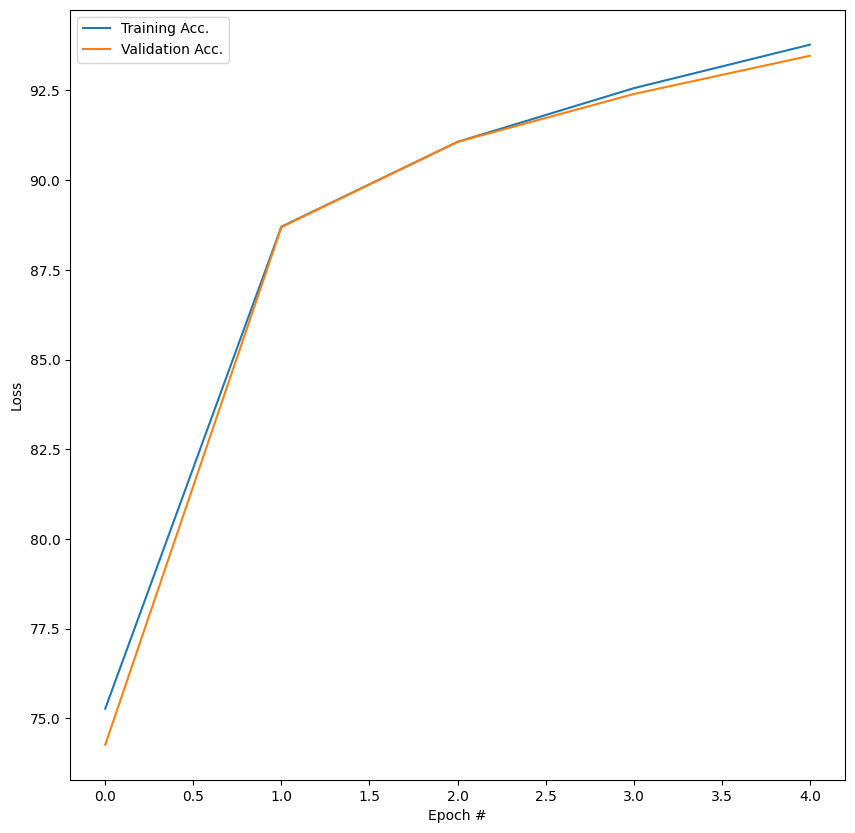

In [39]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

## Learning Rate Tuning

### Learning Rate = 0.025

In [51]:
batch_size_test = 128
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.025)

Epoch 0: training loss: 0.6905459320147832, accuracy: 80.82708333333333
Epoch 0: val. loss: 0.6812607148226272, val. accuracy: 81.08333333333333
Epoch 1: training loss: 0.3839523349404335, accuracy: 89.17083333333333
Epoch 1: val. loss: 0.37499917996056537, val. accuracy: 89.225
Epoch 2: training loss: 0.29528749508659047, accuracy: 91.63125
Epoch 2: val. loss: 0.289042907192352, val. accuracy: 91.51666666666667
Epoch 3: training loss: 0.2453891384402911, accuracy: 92.99583333333334
Epoch 3: val. loss: 0.2403349603347956, val. accuracy: 92.79166666666666
Epoch 4: training loss: 0.20941286481916904, accuracy: 94.05833333333334
Epoch 4: val. loss: 0.20879365658347912, val. accuracy: 93.76666666666667
CPU times: user 1min 23s, sys: 188 ms, total: 1min 23s
Wall time: 1min 26s


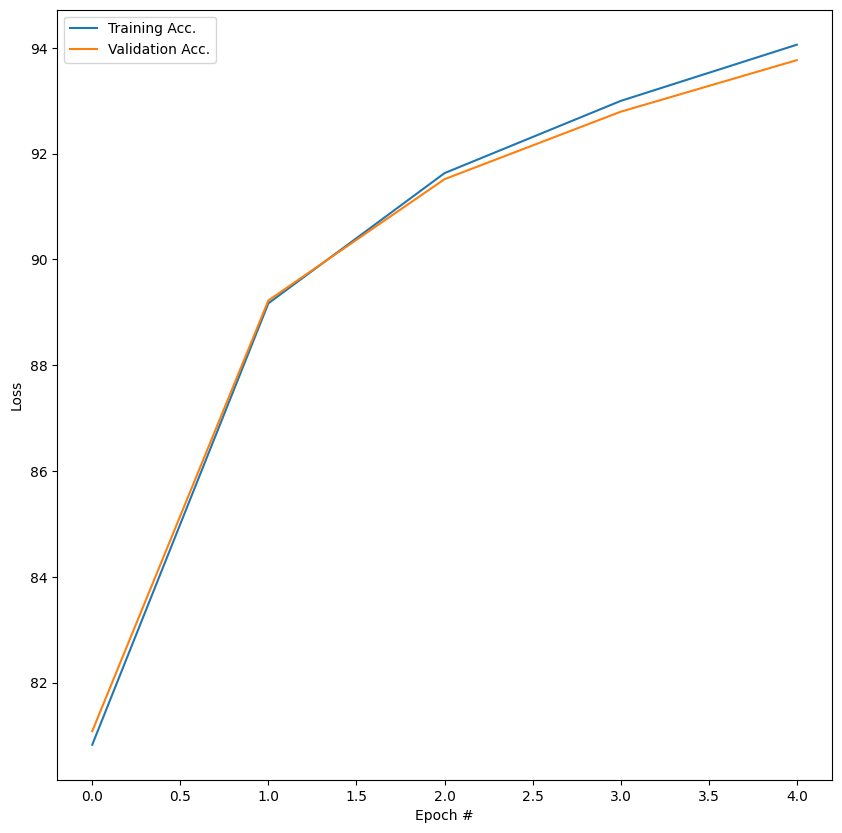

In [52]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

### Learning Rate = 0.075

In [53]:
batch_size_test = 128
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.075)

Epoch 0: training loss: 0.31175093845526375, accuracy: 90.86874999999999
Epoch 0: val. loss: 0.3017490233116327, val. accuracy: 90.75833333333333
Epoch 1: training loss: 0.21149111558000247, accuracy: 93.82083333333333
Epoch 1: val. loss: 0.2126256025376472, val. accuracy: 93.71666666666667
Epoch 2: training loss: 0.15875976330786942, accuracy: 95.35625
Epoch 2: val. loss: 0.1640669946320989, val. accuracy: 95.125
Epoch 3: training loss: 0.13525678733736277, accuracy: 96.06875000000001
Epoch 3: val. loss: 0.14756652255582206, val. accuracy: 95.59166666666667
Epoch 4: training loss: 0.12219300795098145, accuracy: 96.325
Epoch 4: val. loss: 0.13815139626410414, val. accuracy: 95.625
CPU times: user 1min 21s, sys: 181 ms, total: 1min 21s
Wall time: 1min 21s


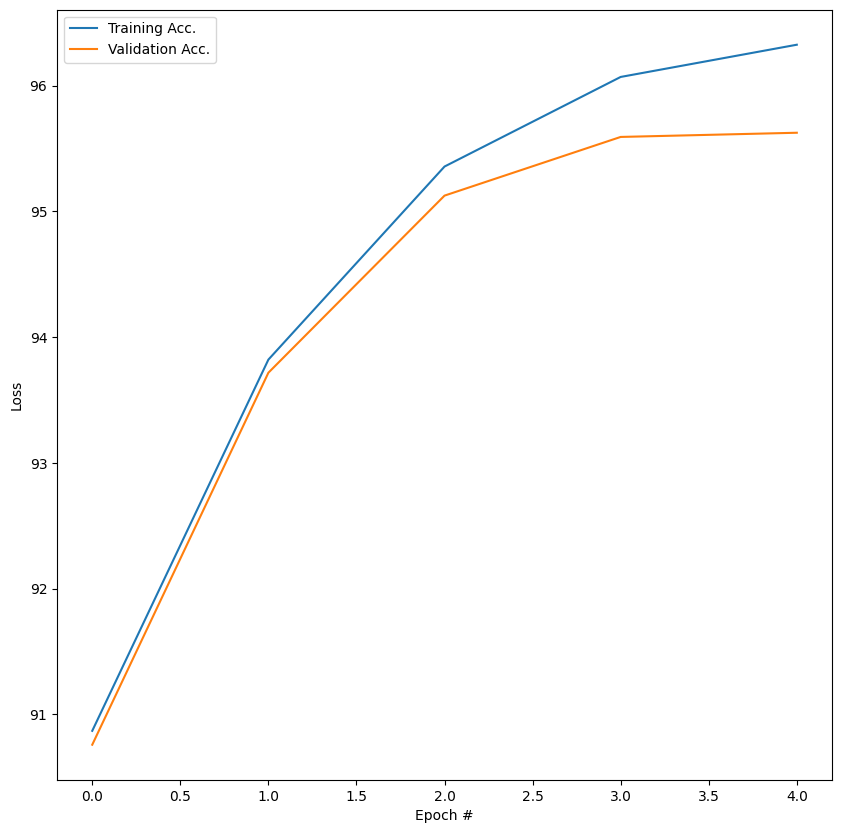

In [54]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

### Learning Rate = 0.10

In [55]:
batch_size_test = 128
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

Epoch 0: training loss: 0.25307868338624634, accuracy: 92.55
Epoch 0: val. loss: 0.249486545199885, val. accuracy: 92.45833333333333
Epoch 1: training loss: 0.17471013242006303, accuracy: 94.75625
Epoch 1: val. loss: 0.1783599544792099, val. accuracy: 94.6
Epoch 2: training loss: 0.14042387379954258, accuracy: 95.78541666666666
Epoch 2: val. loss: 0.1547777738243817, val. accuracy: 95.3
Epoch 3: training loss: 0.1206614364211758, accuracy: 96.29583333333333
Epoch 3: val. loss: 0.13931047565680235, val. accuracy: 95.84166666666667
Epoch 4: training loss: 0.10288891802541912, accuracy: 96.84166666666667
Epoch 4: val. loss: 0.12750587780325812, val. accuracy: 96.13333333333334
CPU times: user 1min 20s, sys: 188 ms, total: 1min 21s
Wall time: 1min 21s


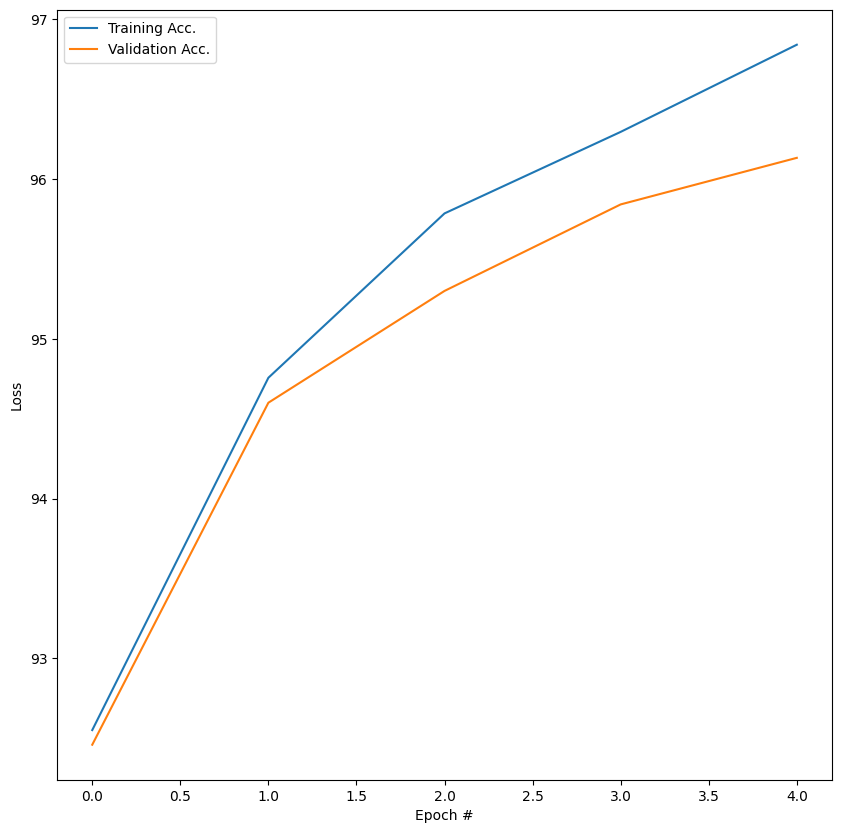

In [56]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

## Activation Functions Tuning

### Activation Function = tanh

In [11]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [15]:
batch_size_test = 128
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

Epoch 0: training loss: 0.5479882551829021, accuracy: 86.16041666666666
Epoch 0: val. loss: 0.5419597086754251, val. accuracy: 86.20833333333333
Epoch 1: training loss: 0.3670435521602631, accuracy: 89.73541666666667
Epoch 1: val. loss: 0.3574032358666684, val. accuracy: 89.91666666666667
Epoch 2: training loss: 0.3189103470245997, accuracy: 90.90208333333332
Epoch 2: val. loss: 0.31053813055474705, val. accuracy: 90.96666666666667
Epoch 3: training loss: 0.2869653928677241, accuracy: 91.81666666666666
Epoch 3: val. loss: 0.28145531588729394, val. accuracy: 91.65833333333333
Epoch 4: training loss: 0.2657280716896057, accuracy: 92.32708333333333
Epoch 4: val. loss: 0.26279638049767373, val. accuracy: 91.95833333333333
CPU times: user 59.9 s, sys: 102 ms, total: 60 s
Wall time: 1min


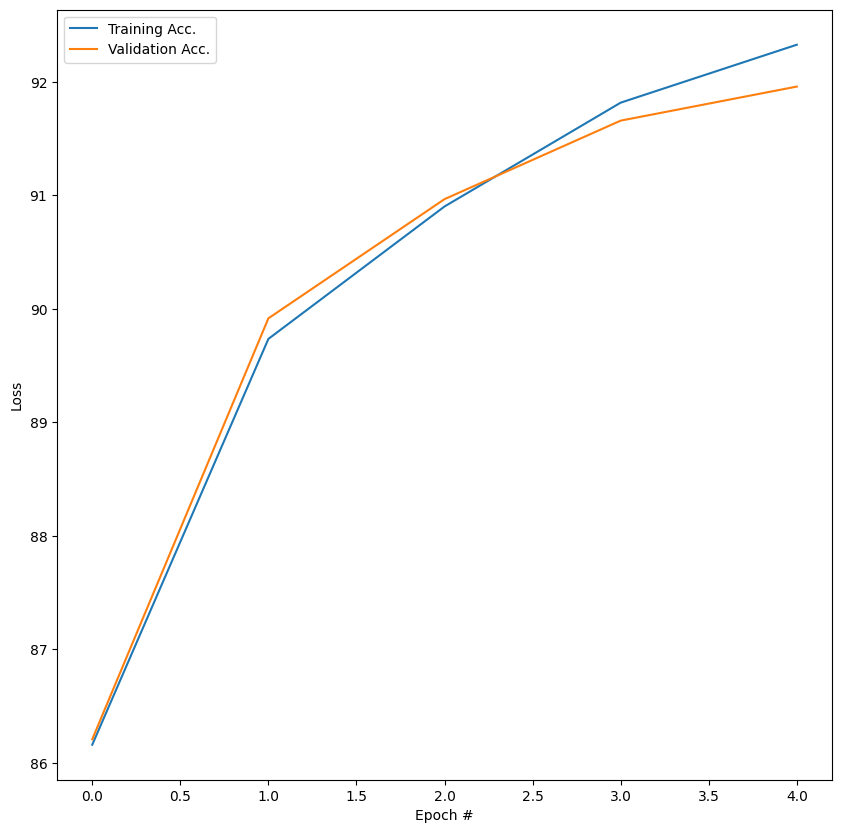

In [13]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

### Activation Function = ELU

In [14]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ELU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ELU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

Epoch 0: training loss: 0.4940138136545817, accuracy: 85.68333333333334
Epoch 0: val. loss: 0.48642438301380647, val. accuracy: 85.32499999999999
Epoch 1: training loss: 0.35105785890420277, accuracy: 89.90208333333334
Epoch 1: val. loss: 0.3398618295471719, val. accuracy: 89.55
Epoch 2: training loss: 0.30446014042695363, accuracy: 91.1875
Epoch 2: val. loss: 0.2948759535842754, val. accuracy: 90.95833333333333
Epoch 3: training loss: 0.26887957857052486, accuracy: 92.18541666666667
Epoch 3: val. loss: 0.26166068548534777, val. accuracy: 92.09166666666667
Epoch 4: training loss: 0.24577634199460346, accuracy: 92.79166666666666
Epoch 4: val. loss: 0.24272479552854884, val. accuracy: 92.80000000000001
CPU times: user 1min, sys: 98.9 ms, total: 1min
Wall time: 1min


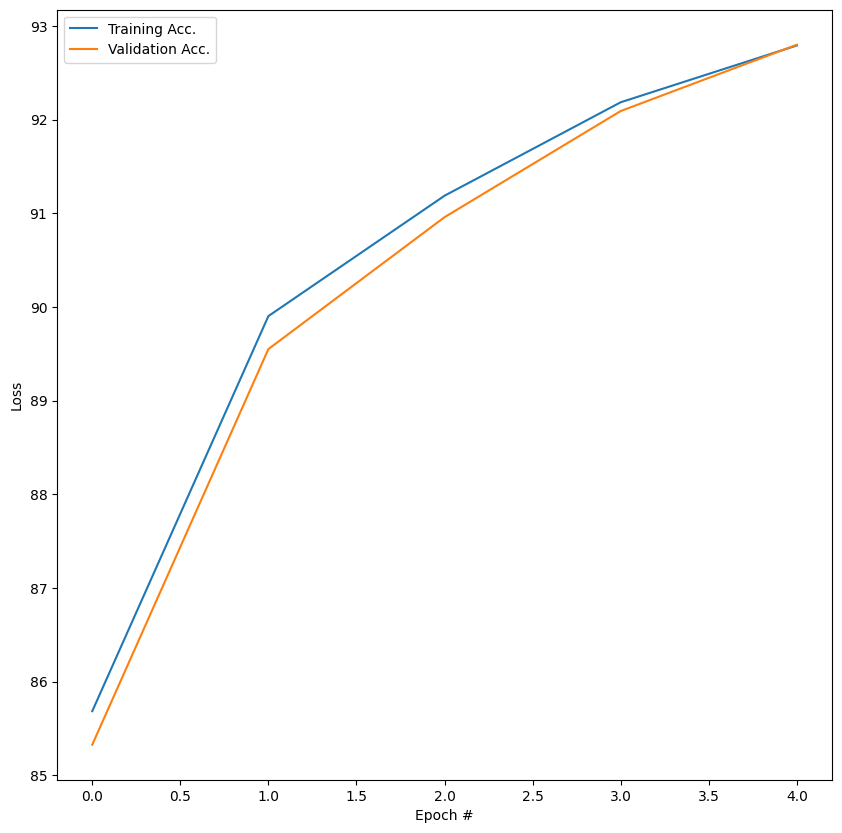

In [16]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

### Activation Function = GELU

In [17]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.GELU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.GELU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

Epoch 0: training loss: 0.22478783589601517, accuracy: 93.40833333333333
Epoch 0: val. loss: 0.22302823442410916, val. accuracy: 93.30000000000001
Epoch 1: training loss: 0.2094417297442754, accuracy: 93.79166666666666
Epoch 1: val. loss: 0.20986151687325316, val. accuracy: 93.60833333333333
Epoch 2: training loss: 0.19149377942085266, accuracy: 94.36666666666666
Epoch 2: val. loss: 0.19502257833138426, val. accuracy: 94.16666666666667
Epoch 3: training loss: 0.1802827967405319, accuracy: 94.75
Epoch 3: val. loss: 0.18532879032353136, val. accuracy: 94.41666666666667
Epoch 4: training loss: 0.16889730115731558, accuracy: 95.05833333333334
Epoch 4: val. loss: 0.17487466406631977, val. accuracy: 94.74166666666667
CPU times: user 1min, sys: 114 ms, total: 1min
Wall time: 1min 2s


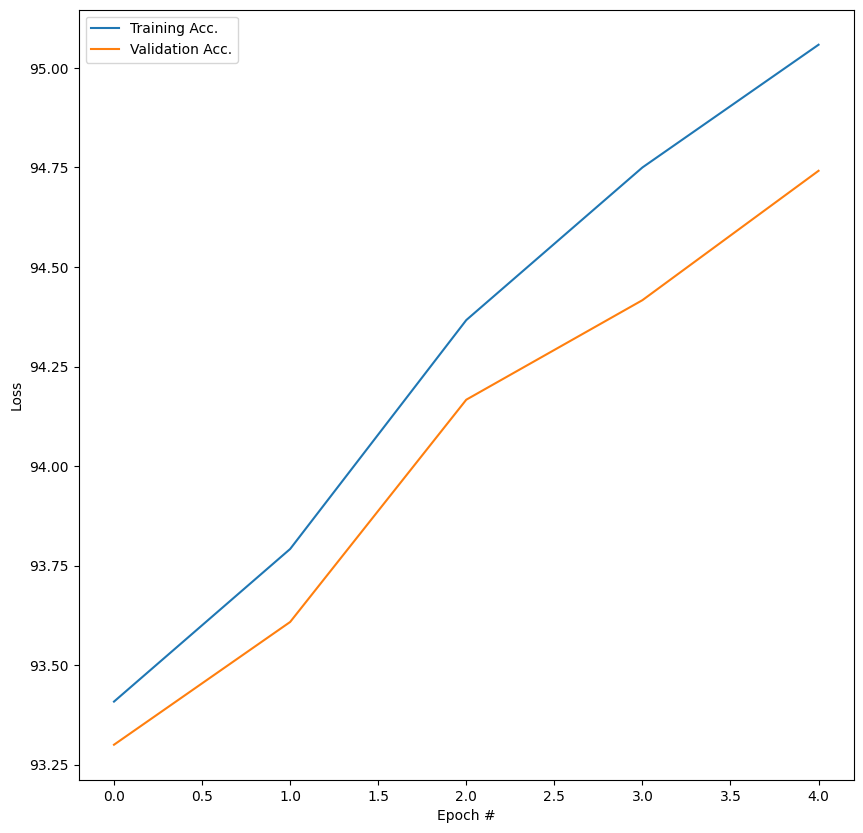

In [18]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()